# Exploratory data analysis before preprocessing
The aim of this notebook is to identify problems with single features. This notebook does not explore the influence of features between eachother. 

Goals:
- Describe every feature
- Identify Problems for every feature
- Collect ideas on how to collapse data, impute missing data or even drop data

TODO: 
- How to handle minorities in category race, eg. "Native Hawaiian or Other Pacific Islander" (3 observations) or "American Indian or Alaska Native" (1 observation)
- Suggest renaming of feature "loc" as it is also function used in pandas
- Inquire about the purpose of the feature "other"

In [35]:
# imports (install missing libraries by running "!pip install 'libraryname'" in a cell)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import missingno as msno 
sys.path.insert(0, '../preprocessing/')
import pipe

# set plot style and size:
sns.set(rc={'figure.figsize':(9,6)})
sns.set_style("ticks")
f'pandas version: {pd.__version__}'

'pandas version: 1.1.3'

## Helper functions

In [2]:
def countplot(df, column, title, subtitle, xlabel, ylabel, xtick_rotation = None):
    g = sns.countplot(x=df[column])

    # Title, Subtitle and Axis
    g.text(x=0.5, 
            y=1.06, 
            s=title, 
            fontsize=10, weight='bold', ha='center', va='bottom', transform=g.transAxes)
    g.text(x=0.5, 
            y=1.01, 
            s=subtitle, 
            fontsize=10, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xtick_rotation is not None:
        plt.xticks(rotation=xtick_rotation)
    plt.show()

In [3]:
# import dataframe
df = pd.read_excel("../data/uveitis_data.xlsx")
assert len(df) >= 1075, "Data is not complete"

# rename columns
df = pipe.rename(df, "../data/col_names&data_type-Copy1.xlsx")

## Missing Values

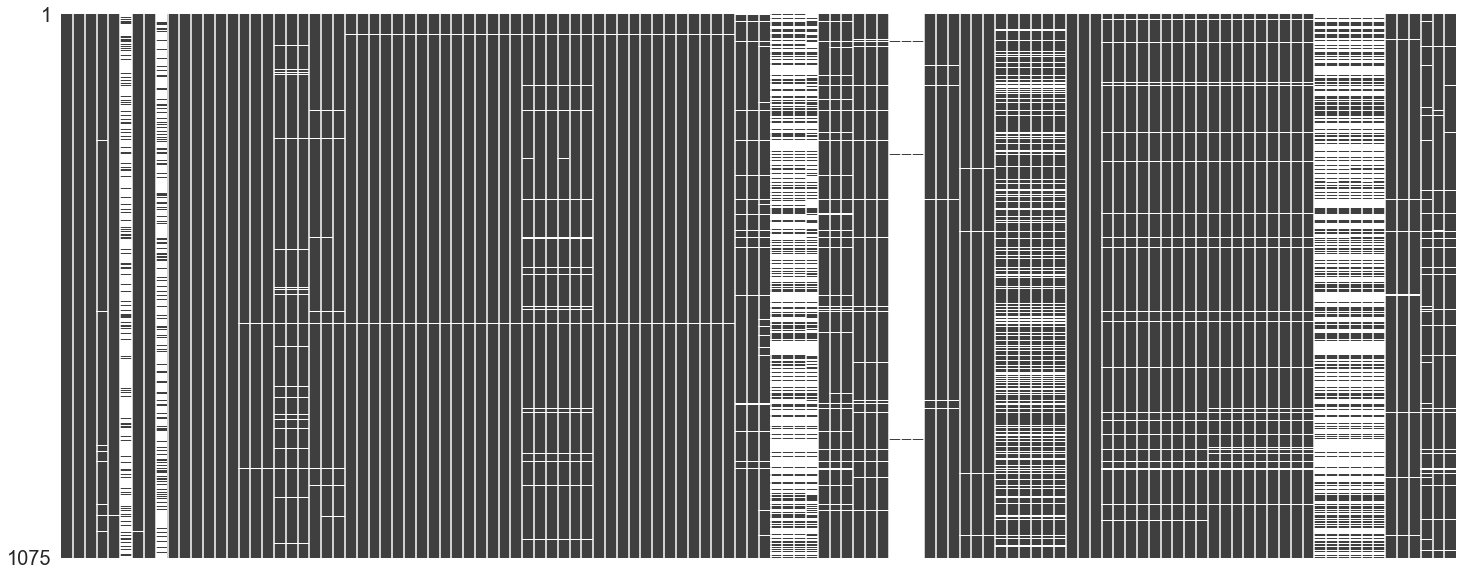

In [4]:
msno.matrix(df, sparkline=False);

In [5]:
df.head()

,id,gender,race,loc,cat,other_,ehr_diagnosis,specific_diagnosis,notes,ac_abn_od_cells,...,range34,proteinase-3_antibodies,uom35,range35,rheumatoid_factor,uom36,range36,hbc__ab,hbs__ag,hcv__ab
0,1,Male,Black/African American,Anterior,Nonneoplastic Masquerade,NaN,Posner-Schlossman ...,Idiopathic_anterior,NaN,0,...,NaN,NaN,NaN,NaN,<15,IU/mL,<15,NEGATIVE,NEGATIVE,NEGATIVE
1,2,Female,Black/African American,Intermediate,Idiopathic,NaN,Ant/Int Uveitis ...,pars planitis,pars planitis,2,...,<0.4 (Negative),<0.2,U,<0.4 (Negative),<10,IU/mL,<13,NEGATIVE,NEGATIVE,NEGATIVE
2,3,Female,White,Pan,Systemic,NaN,VKH,VKH,NaN,0.5,...,NaN,NaN,NaN,NaN,<10,IU/mL,<13,NEGATIVE,NEGATIVE,NEGATIVE
3,4,Female,White,Anterior,Idiopathic,NaN,chronic idiopathic anterior uveitis ...,Idiopathic_anterior,NaN,0,...,NaN,NaN,NaN,NaN,<15,IU/mL,<15,NEGATIVE,NEGATIVE,NEGATIVE
4,5,Female,Unknown Race,Anterior,Idiopathic,NaN,Acute Anterior Uveitis ...,Idiopathic_anterior,NaN,0,...,NaN,NaN,NaN,NaN,<10,IU/mL,<13,NEGATIVE,NEGATIVE,NEGATIVE


In [6]:
df.columns.tolist()

['id',
 'gender',
 'race',
 'loc',
 'cat',
 'other_',
 'ehr_diagnosis',
 'specific_diagnosis',
 'notes',
 'ac_abn_od_cells',
 'ac_abn_os_cells',
 'vit_abn_od_cells',
 'vit_abn_os_cells',
 'vit_abn_od_haze',
 'vit_abn_os_haze',
 'calcium',
 'uom',
 'range',
 'lactate_dehydrogenase',
 'uom1',
 'range1',
 'c-reactive_protein,_normal_and_high_sensitivity',
 'uom2',
 'range2',
 'wbc',
 'uom3',
 'range3',
 'rbc',
 'uom4',
 'range4',
 'hemoglobin',
 'uom5',
 'range5',
 'hematocrit',
 'uom6',
 'range6',
 'mcv',
 'uom7',
 'range7',
 'mch',
 'uom8',
 'range8',
 'mchc',
 'uom9',
 'range9',
 'rdw',
 'uom10',
 'range10',
 'platelet_count',
 'uom11',
 'range11',
 'neutrophil_%',
 'uom12',
 'range12',
 'lymphocytes_%',
 'uom13',
 'range13',
 'angiotensin_conv#enzyme',
 'uom14',
 'range14',
 'beta-2-microglobulin',
 'uom15',
 'range15',
 'lupus_anticoagulant',
 'lysozyme,_plasma',
 'uom18',
 'range18',
 'anti-ccp_ab',
 'uom21',
 'range21',
 'anti-dnase_b',
 'uom22',
 'range22',
 'anti-ena_screen',
 'u

## id
Unique identifier of an observation, aka a patient

In [7]:
assert len(df['id'].unique()) == len(df['id']), "Id is not unique"

In [8]:
df.id.sample(3)

92      93
678    679
148    149
Name: id, dtype: int64

## gender
A categorical variable that defines the gender of a patient

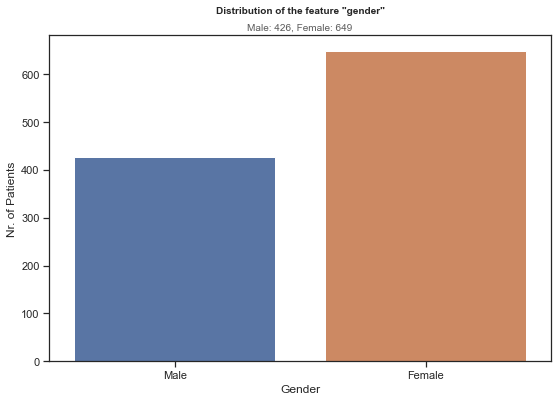

In [9]:
count = df.gender.value_counts()
n_male, n_female = count['Male'], count['Female']
countplot(df, 'gender', f'Distribution of the feature "gender"', f'Male: {n_male}, Female: {n_female}', f'Gender', f'Nr. of Patients')

## race
Describes the ethnicity of the patient. This information is provided by the patient himself.

In [10]:
df.race.value_counts()

White                                               490
Black/African American                              381
Asian                                                94
Unknown Race                                         74
Multiracial                                          31
Native Hawaiian or Other Pacific Islander             3
American Indian or Alaska Native                      1
Race or Ethnic Group Data Not Provided by Source      1
Name: race, dtype: int64

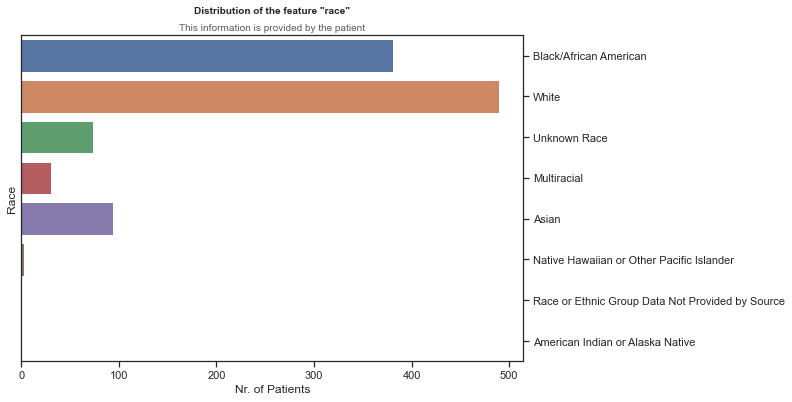

In [11]:
count = df.race.value_counts()
g = sns.countplot(y=df.race)

# Title, Subtitle and Axis
g.text(x=0.5, 
        y=1.06, 
        s=f'Distribution of the feature "race"', 
        fontsize=10, weight='bold', ha='center', va='bottom', transform=g.transAxes)
g.text(x=0.5, 
        y=1.01, 
        s=f'This information is provided by the patient', 
        fontsize=10, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
g.yaxis.tick_right()
# g.yaxis.set_label_position("right")
plt.ylabel(f'Race')
plt.xlabel(f'Nr. of Patients')
plt.show()

In the graph we can see that there is both the category "Unknown Race" (74 observations) and "Race or Ethnic Group Data Not Provided by Source" (1 observation). We suggest to consider both categories as "Missing Values" and to combine them. Also, there are categories that hardly appear in the dataset. These include "Native Hawaiian or Other Pacific Islander" (3 observations) or "American Indian or Alaska Native" (1 observation). 

## loc
aka "Location" describes the location of the inflammation in the eye.

In [12]:
df['loc'] = df['loc'].str.lower().str.strip()
df['loc'].replace({'pan':'panuveitis'})
df['loc'] = df['loc'].astype('category')
df['loc'].value_counts(dropna=False)

posterior       341
anterior        242
pan             221
intermediate    182
scleritis        71
NaN              11
panuveitis        7
Name: loc, dtype: int64

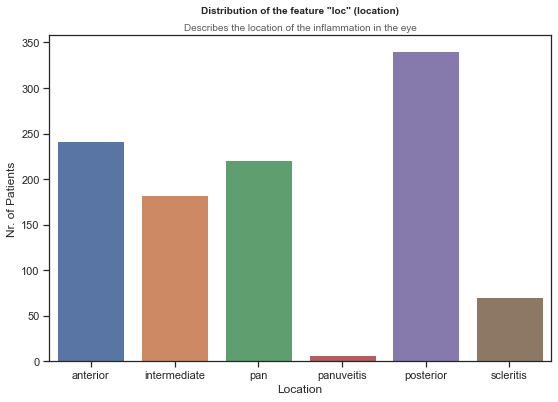

In [13]:
countplot(df, 'loc', f'Distribution of the feature "loc" (location)', 'Describes the location of the inflammation in the eye', f'Location', f'Nr. of Patients')

In [14]:
df.ac_abn_od_cells.value_counts()

0       738
0.5      74
0.5      71
1        70
0        64
2        31
3        17
4         5
1         2
C         2
2         1
Name: ac_abn_od_cells, dtype: int64

In addition to the categories anterior (lat. in front), posterior (lat. in back) and intermediate, there is the category panuveities which is an inflammation of the whole uvea tract as well as the retina and the vitreous humor (glass body) (see Bansal et al., 2010). The category "scleritis" refers to inflammation of episcleral and scleral tissue (see Alan et al., o. J.). 

## cat
cat ("Category") describes the origin of the inflammation. This can be, for example, systematic, infectious or idiopathic. This feature is based on the results of laboratory tests and has therefore been recorded retrospectively. However, it is interesting to make a prediction about the patient without the need of manualy aggregated information. We recommend trying to find a model that does not use this feature.

In [15]:
df.cat = df.cat.str.lower().str.strip().astype('category')
df.cat.value_counts(dropna=False)

idiopathic                  530
systemic                    192
wds                         124
nonneoplastic masquerade    117
infectious                   87
neoplastic masquerade        22
NaN                           1
scleritis                     1
not_uveitis                   1
Name: cat, dtype: int64

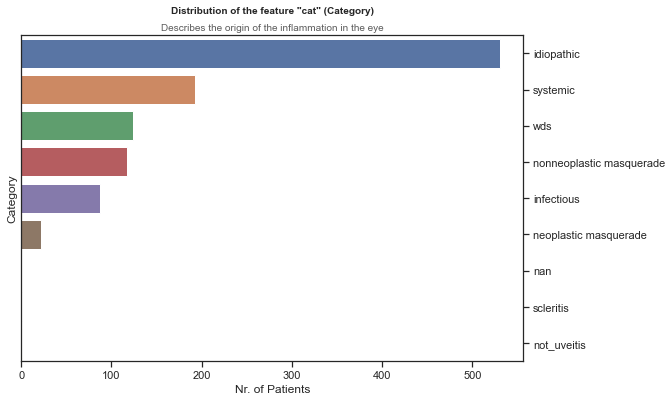

In [16]:
g = sns.countplot(y="cat", data=df, order = df['cat'].value_counts(dropna=False).index )

# Title, Subtitle and Axis
g.text(x=0.5, 
        y=1.06, 
        s=f'Distribution of the feature "cat" (Category)', 
        fontsize=10, weight='bold', ha='center', va='bottom', transform=g.transAxes)
g.text(x=0.5, 
        y=1.01, 
        s= 'Describes the origin of the inflammation in the eye', 
        fontsize=10, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
g.yaxis.tick_right()
# g.yaxis.set_label_position("right")
plt.ylabel(f'Category')
plt.xlabel(f'Nr. of Patients')
plt.show()

More than 400 of the observations are idiopathic, i.e. the cause is unknown. Furthermore, the category panuveitis often exists, followed by wds (white dot syndromes) and systemic or infectious origin. Categories containing the term "masquerade" refer to a form of pseudo-uveitis (see Smith et al., 1986). The inflammation appears to be uveitis, but it is not. There is also an observation of scleritis and one labeled "not_uveitis". We advise to combine all forms of pseudo-uveitis and treat the categories with only one observation as missing values.

## other_

In [17]:
print(f'{round(df.other_.isna().sum()/len(df),3)*100} % missing values')

79.10000000000001 % missing values


In [18]:
df.other_.unique()

array([nan, 'RV', 'CME', 'Granulomatous', 'CNV', 'CR granuloma',
       'Granulomatous, RV', 'BRAO', 'RV; CME', 'granulomatous',
       'granulomatous, pars planitis', 'pars planitis',
       'Granulomatous, pars planitis', 'RV, pars planitis',
       'Choroidal Granuloma ', 'granulomatous, RV', 'pars planitis, RV',
       'GRanulomatous'], dtype=object)

## ehr_diagnosis
EHR diagnosos is an electronic transmitted diagnosis, usually given beforehand by another doctor, not knowing about the lab results and final diagnosis. This feature contains a lot of diffrent categories (533 unique values). 

In [19]:
print(f'{round(df.ehr_diagnosis.isna().sum()/len(df),3)*100} % missing values')

0.2 % missing values


In [20]:
print(f'{len(df.ehr_diagnosis.str.strip().str.lower().unique())} unique values')

657 unique values


In [21]:
df.ehr_diagnosis.str.strip().str.lower().value_counts(dropna=False)

intermediate uveitis                                                   39
anterior uveitis                                                       36
ng anterior uveitis                                                    26
anterior and intermediate uveitis                                      21
panuveitis                                                             20
                                                                       ..
ocular syphilis                                                         1
neuroretinitis (+ bartonella)                                           1
chronic intermediate uveitis                                            1
behcet's disease - incomplete type                                      1
idiopathic ng panuveitis / anterior uveitis with retinal vasculitis     1
Name: ehr_diagnosis, Length: 657, dtype: int64

## specific_diagnosis 
This feature is considered by the client to be the most important target variable. It indicates the diagnosis after laboratory testing by the team that provided the dataset. Some categories, such as "idiopathic_anterior" and "idopathic_scleritis" can probably be combined after consultation with the client. Diagnoses that cannot be assigned to a form of uveitis could be designated as "not_uveitis" and grouped together. 

In [22]:
df.specific_diagnosis.str.lower().str.strip().value_counts(dropna=False)

idiopathic_anterior         169
pars planitis               145
nonneoplastic masquerade    115
idiopathic_panuveitis       107
wds                          92
idiopathic_posterior         58
idiopathic_scleritis         57
vkh                          45
toxoplasmosis                34
presumed_sarcoidosis         33
bcr                          32
bx_proven_sarcoidosis        26
viral                        25
rheumatologic                24
neoplastic masquerade        21
hla_b27                      21
behcet                       19
tuberculosis                 13
multiple_sclerosis           12
syphilis                     10
jia                           6
bartonella                    4
toxocariasis                  2
tinu                          2
zika                          1
not_uveitis                   1
lyme                          1
Name: specific_diagnosis, dtype: int64

## notes 

Contains notes/comments on the specific diagnosis. This feature has about 60% missing values. At this stage it is a candidate to be dropped. Later it should be checked how the data is related to the feature specific_diagnosis.

In [23]:
print(f'{round(df.notes.isna().sum()/len(df),2)*100} % missing values')

79.0 % missing values


In [24]:
df.notes.value_counts(dropna=False)

NaN              850
pars planitis    142
WDS               80
lymphoma           2
PIC                1
Name: notes, dtype: int64

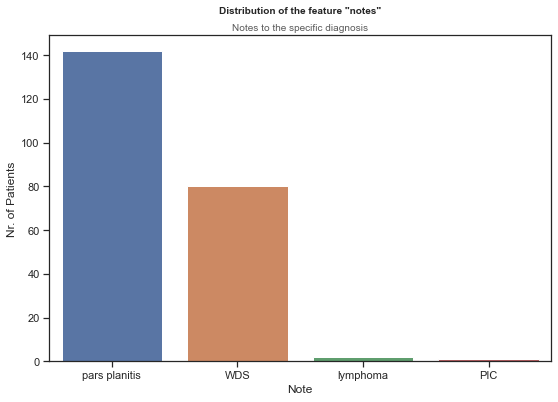

In [25]:
countplot(df, 'notes', f'Distribution of the feature "notes"', 'Notes to the specific diagnosis', f'Note', f'Nr. of Patients')

## AC Abn Od Cells and AC Abn Os Cells
These qualitative, ordinal features describe the severity of the inflammation of the Anterior Chamber Cells (AC) in either the left eye (OS) or the right eye (OD). The inflammation can be rated as 0, +0.5, +1, +2, +3, +4. The higher the value the more severe the inflammation is. If either one of these values a patient can be considered as "Active", else as "Quiet". This information could be recorded in a new column. Values marked with 'C' (C = Cannot) can be treated as missing as they indicate that the level of inlammation could not be measured.

In [26]:
df.ac_abn_od_cells.str.strip().str.lower().value_counts()

0      802
1       72
0.5     71
2       32
3       17
4        5
c        2
Name: ac_abn_od_cells, dtype: int64

In [27]:
df.ac_abn_os_cells.str.strip().str.lower().value_counts()

0      795
0.5     79
1       72
2       37
3       10
c        4
4        4
Name: ac_abn_os_cells, dtype: int64

## Vit Abn Od Cells, Vit Abn Os Cells, Vit Abn Od Haze and Vit Abn Os Haze
These features describe (similar to AC Abn O...) the inflammation of cells in the left (OS) and right (OD) eye. The same scale of 0, +0.5, +1, +2, +3, +4 is used. If one of the values is higher than 0 the patient is considered to be "Active" as well. This information can be recorded in a new column as well.

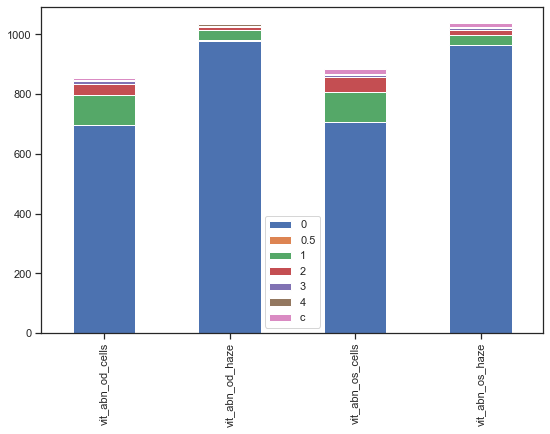

In [28]:
a = df.vit_abn_od_cells.str.strip().str.lower().value_counts()
b = df.vit_abn_od_haze.str.strip().str.lower().value_counts()
c = df.vit_abn_os_cells.str.strip().str.lower().value_counts()
d = df.vit_abn_os_haze.str.strip().str.lower().value_counts()
t = pd.concat([a,b,c,d],axis=1)
t = t.sort_index(ascending=True)
t.T.plot(kind='bar', stacked=True);

### hbc__ab, hbs__ag and hcv__ab

df.loc[df['hbs__ag']These columns encode the lab results for diffrent types of hepatitis. We encode these in binary form. Negative results are '0' and positive results get encoded as '1'. There are some cases where neither a positive or negative result can be identified. These values will be set as missing values. 

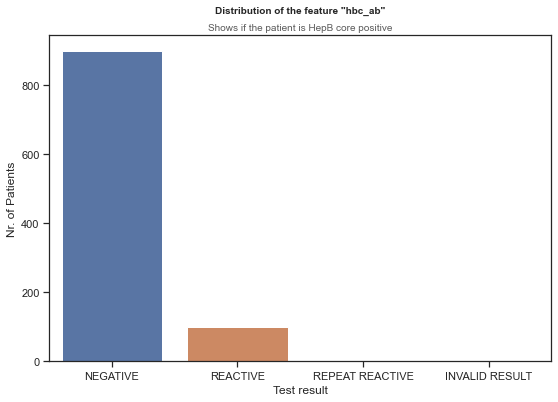

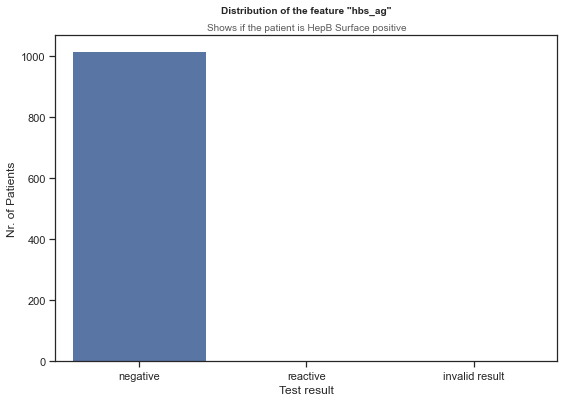

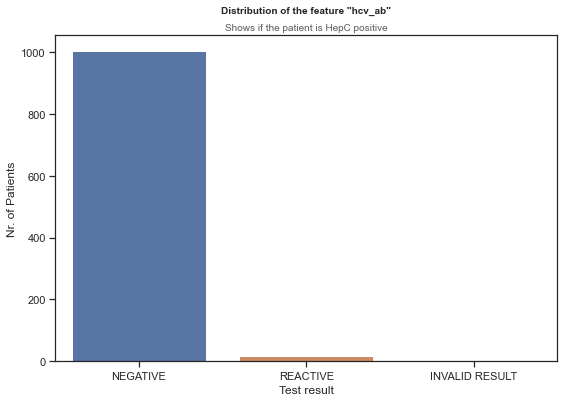

In [29]:
# barplot hepatitis-columns
countplot(df, 'hbc__ab', f'Distribution of the feature "hbc_ab"', 'Shows if the patient is HepB core positive', f'Test result', f'Nr. of Patients')
df['hbs__ag'] = df['hbs__ag'].str.lower()
df.loc[df['hbs__ag'] == 'see note | positive result s/co ratio is >5.0.  confirmatory testing i', 'hbs__ag'] = 'reactive'
df.loc[df['hbs__ag'] == 'see below | positive result s/co ratio is >5.0.  confirmatory testing ', 'hbs__ag'] = 'reactive'
df.loc[df['hbs__ag'] == 'note:', 'hbs__ag'] = np.nan
countplot(df, 'hbs__ag', f'Distribution of the feature "hbs_ag"', 'Shows if the patient is HepB Surface positive', f'Test result', f'Nr. of Patients')
    
countplot(df, 'hcv__ab', f'Distribution of the feature "hcv_ab"', 'Shows if the patient is HepC positive', f'Test result', f'Nr. of Patients')

In [30]:
type(df)

pandas.core.frame.DataFrame

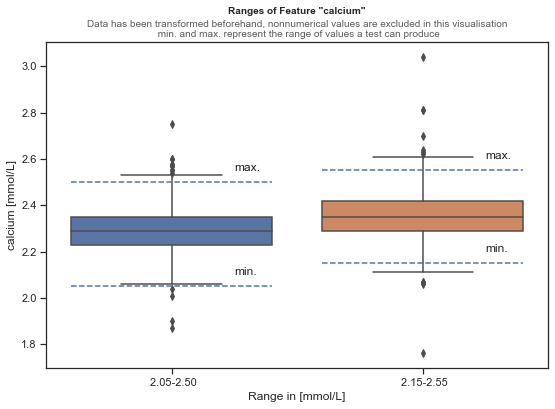

In [31]:
def plot_range(data, feat, verbose=False):
    data = pipe.extract_num(data, feat, verbose=verbose)
    sns.set(rc={'figure.figsize':(9,6)})
    sns.set_style("ticks")
    
    # extract uom and ranges for feat
    sub_data = data.loc[:,feat:].iloc[:,:3]
    sub_range = sub_data.loc[:,sub_data.columns[sub_data.columns.str.contains(pat = 'range')]]
    # plot boxplot for every "range" and corresponding uom
    g = sns.boxplot(x=sub_range.iloc[:,0],y=sub_data[feat])
    # overlay min and max range
    ranges = [x for x in sub_range.iloc[:,0].unique() if str(x) != 'nan']
    n_range = len(ranges)
    for num, rang in enumerate(ranges):
        if isinstance(rang, str):
            min_range, max_range = rang.split('-')
            min_range, max_range = float(min_range), float(max_range)
            g.axhline(min_range, xmin=num/n_range+.05, xmax=num/n_range+(1/n_range-.05), ls='--')
            g.axhline(max_range, xmin=num/n_range+.05, xmax=num/n_range+(1/n_range-.05), ls='--')
            g.text(num+0.25,max_range+0.05, "max.")
            g.text(num+0.25,min_range+0.05, "min.")
            
    
    # Title, Subtitle and Axis
    g.text(x=0.5, 
            y=1.08, 
            s=f'Ranges of Feature "{feat}"', 
            fontsize=10, weight='bold', ha='center', va='bottom', transform=g.transAxes)
    g.text(x=0.5, 
            y=1.01, 
            s=f'Data has been transformed beforehand, nonnumerical values are excluded in this visualisation\n min. and max. represent the range of values a test can produce', 
            fontsize=10, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
    plt.xlabel(f'Range in [{sub_data.iloc[1,1]}]')
    plt.ylabel(f'{feat} [{sub_data.iloc[1,1]}]')

    

    plt.show()
    
plot_range(df, "calcium")

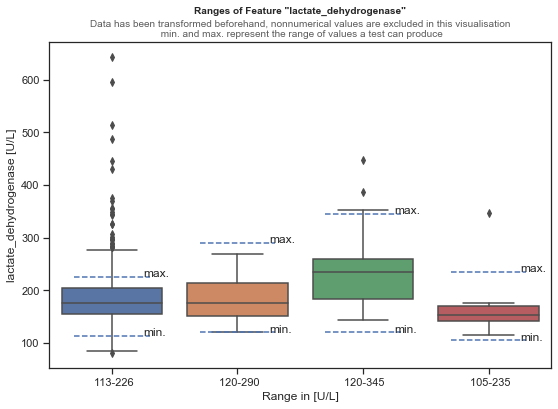

In [32]:
plot_range(df, "lactate_dehydrogenase")

### Sources 

Bansal, R., Gupta, V., & Gupta, A. (2010). Current approach in the diagnosis and management of panuveitis. Indian Journal of Ophthalmology, 58(1), 45–54. https://doi.org/10.4103/0301-4738.58471

Alan, P. M., Feldman M.D., B. H., Hung, J., Tsai, J. H., & Hossain, Dr. K. (o. J.). Scleritis—EyeWiki. Abgerufen 12. März 2021, von https://eyewiki.aao.org/Scleritis

Smith, R. E., Nozik, R. A., & Grabner, G. (1986). Pseudouveitis („Maskerade-Syndrome“). In R. E. Smith, R. A. Nozik, & G. Grabner (Hrsg.), Uveitis: Klinik, Diagnose, Therapie Ein Leidfaden für die Praxis (S. 238–241). Springer. https://doi.org/10.1007/978-3-642-70809-1_38
